# Inference and Validation


In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Extracting F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST/raw


Extracting F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST/raw



Extracting F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST/raw


Extracting F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
            drop_p: float between 0 and 1, dropout probability
        '''
        super().__init__()
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        # Forward through each layer in `hidden_layers`, with ReLU activation and dropout
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
        
        x = self.output(x)
        
        return F.log_softmax(x, dim=1) # Avoid values too close to 0 or 1, and stretches range

In [4]:
# Create the network, define the criterion and optimizer
model = Network(784, 10, [516, 256], drop_p=0.5)
criterion = nn.NLLLoss() # Netgative Log Likehood Loss, expects log_softmax as input
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [0]:
# Validation
def validate(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:
        images.resize_(images.shape[0], 784)
        output = model.forward(images)

        test_loss += criterion(output, labels).item()
        ps = torch.exp(output) # Output is log_softmax, exp returns softmax
        probs, idxs = ps.max(dim=1) # Get highest probs and corresponding idx for dim=1 containing class labels
        equals = labels.data == idxs
        accuracy += equals.type(torch.FloatTensor).mean()

    return test_loss, accuracy

In [6]:
epochs = 2
steps = 0
running_loss = 0
print_every = 40
for e in range(epochs):
    for images, labels in trainloader:
        steps += 1
        
        # Flatten images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            # Switch to eval mode. Turns off dropout. Useful during inference and validation
            model.eval()
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                test_loss, accuracy = validate(model, testloader, criterion)
                
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            
            # Switch back to train mode
            model.train()

Epoch: 1/2..  Training Loss: 1.314..  Test Loss: 0.805..  Test Accuracy: 0.703
Epoch: 1/2..  Training Loss: 0.805..  Test Loss: 0.636..  Test Accuracy: 0.757
Epoch: 1/2..  Training Loss: 0.727..  Test Loss: 0.599..  Test Accuracy: 0.771
Epoch: 1/2..  Training Loss: 0.626..  Test Loss: 0.576..  Test Accuracy: 0.782
Epoch: 1/2..  Training Loss: 0.648..  Test Loss: 0.560..  Test Accuracy: 0.794
Epoch: 1/2..  Training Loss: 0.635..  Test Loss: 0.538..  Test Accuracy: 0.801
Epoch: 1/2..  Training Loss: 0.596..  Test Loss: 0.522..  Test Accuracy: 0.803
Epoch: 1/2..  Training Loss: 0.598..  Test Loss: 0.519..  Test Accuracy: 0.811
Epoch: 1/2..  Training Loss: 0.620..  Test Loss: 0.531..  Test Accuracy: 0.807
Epoch: 1/2..  Training Loss: 0.558..  Test Loss: 0.505..  Test Accuracy: 0.818
Epoch: 1/2..  Training Loss: 0.603..  Test Loss: 0.516..  Test Accuracy: 0.807
Epoch: 1/2..  Training Loss: 0.541..  Test Loss: 0.513..  Test Accuracy: 0.805
Epoch: 1/2..  Training Loss: 0.567..  Test Loss: 0.4

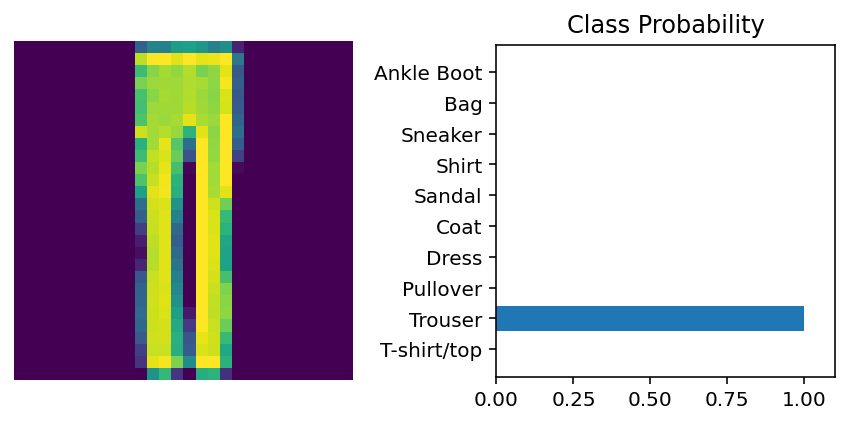

In [7]:
# Inference

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[np.random.choice(images.size()[0])]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
img.resize_(1, 28, 28)
ps = ps.data.numpy().squeeze()
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
ax1.axis('off')
ax2.barh(np.arange(10), ps)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(['T-shirt/top',
                     'Trouser',
                     'Pullover',
                     'Dress',
                     'Coat',
                     'Sandal',
                     'Shirt',
                     'Sneaker',
                     'Bag',
                     'Ankle Boot'], size='medium');

ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()